In [18]:
from newsapi import NewsApiClient
import json
import requests as rq
import re, os
import nltk
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords
import string

#Put in your own key
newsapi = NewsApiClient(api_key='b38b1480c4a1405492e1fbdb4228e87b')

#Example country lists
country_list = ['US', 'Denmark', 'China', 'Italy']
#Our countries of interest
long_list = ['US', 'India', 'U.K.', 'Italy', 'Taiwan', 'South Korea', 'China', 'Denmark', 'Japan']
def get_country(country):
    """ Retrieve all articls related to COVID-19 and specified country
    Can alter the param dates in YYYY-MM-DD format
    
    sort_by can be relevancy or popularity, we chose relevancy because of the overlap
    with popularity and because of the article sometimes lacking relevancy appearing in popularity.
    
    One could modify this function to retrieve 100 articles per day to retrieve more data over
    a longer period of time, but this would draw from the query limit imposed on developer api key
    """
    all_articles = newsapi.get_everything(q='COVID-19-AND-'+country,
                                          #domains='wsj.com,nytimes.com',
                                          from_param='2020-05-04',
                                          to='2020-04-05',
                                          language='en',
                                          sort_by='relevancy',
                                          #Max amount of articles per query with develop api key is 100
                                          page_size=100)
    return all_articles

#Get content w/o focus on the date
def get_content(country_dict):
    content_list = []
    for article in country_dict['articles']:
        content_list.append((article['source']['name'],
                            article['title'],
                            article['content']))
    return content_list

#Date stored in published at with the folllowing format:
#"publishedAt":"2020-05-07T14:13:22Z", so we'll trim,
#The format always has a leading 0, so 10 chars is all we should need
#will parse through with datetime later
def get_content_date(country_dict):
    content_list = []
    for article in country_dict['articles']:
        content_list.append((article['source']['name'],
                             article['publishedAt'][:10],
                            article['title'],
                            article['content']))
    return content_list #List of tuples with source date, title, and article

#Example
#china = get_country('China')
#china_content = get_content(china)
#china_content = get_content_date(china)
#print(china_content)

#other example
#print(get_content(get_country('Denmark')))
    
    

In [19]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from collections import defaultdict
senti = SentimentIntensityAnalyzer()


#This one for all sentences made by the source
def per_sent_scorer(content):
    """ Takes the content from the list of tuples and converts to dict with source as keys.
    This function is used to see the overall sentiment a news source expresses towards a country.
    Scores each sentence rather than the article as a whole
    """
    #Extract sentences
    source_dict = defaultdict(list)
    for source in content: #Source is a tup with source, title, article
        if source[2] is None:
            continue
        full_article = source[1] + '. ' +source[2] #period so title is sep sentence
        sentences = sent_tokenize(full_article)
        #With developer api, limit on the article length therefore can remove last sentence that ends in [+#chars]
        if sentences[-1][-1] == ']':
            sentences = sentences[:-1]
        for sentence in sentences:
            source_dict[source[0]].append(senti.polarity_scores(sentence))
    return source_dict #Dict, Key = Source, Value = List of scores per sentence
#Ex.
#print(per_sent_scorer(china_content))




In [20]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import collections
senti = SentimentIntensityAnalyzer()

def art_scorer(content):
    """VADER does a pretty good job at scoring sentences and multiple sentences
    taking into account capitalization and punctuation. Therefore this functions
    scores articles as a whole and stores them"""
    #Extract sentences
    source_dict = defaultdict(list)
    for source in content: #Source is a tup with source, title, article
        if source[2] is None:
            continue
        full_article = source[1] + '. ' +source[2]
        source_dict[source[0]].append(senti.polarity_scores(full_article))
    #Returns a dict witk keys= sources, value= list of dictionary senti score of each article
    return source_dict
#Ex
#print(art_scorer(china_content))

In [21]:
#Ex of dictionaries retrieved by country 
def country_per_sent_scores(state):
    state_content = get_content(get_country(state))
    return per_sent_scorer(state_content)

def country_full_art_scores(state):
    state_content = get_content(get_country(state))
    return art_scorer(state_content)
    
for country in country_list:
    print(country, country_per_sent_scores(country), '\n')   

for country in country_list:
    print(country, country_full_art_scores(country), '\n')
'''

"\ndef country_per_sent_scores(state):\n    state_content = get_content(get_country(state))\n    return per_sent_scorer(state_content)\n\ndef country_full_art_scores(state):\n    state_content = get_content(get_country(state))\n    return art_scorer(state_content)\n    \nfor country in country_list:\n    print(country, country_per_sent_scores(country), '\n')   \n\nfor country in country_list:\n    print(country, country_full_art_scores(country), '\n')\n"

In [22]:
#Does a full article score
def track_by_date(state):
    """To follow trends of sentiment, this function uses get content date function.
    
    Returns a dictionary with Key=date and Values= list of dictionary senti scores
    """
    state_content = get_content_date(get_country(state)) #ist of tup (source, date, title, article)
    source_dict = defaultdict(list)
    
    #Scoring full article, could alternatively split the article
    for source in state_content: #Source is a tup with (source, date, title, article)
        if source[3] is None:
            continue
        full_article = source[2] + '. ' +source[3] #title sep by period
        source_dict[source[1]].append(senti.polarity_scores(full_article))
    return source_dict
#Ex
#track_by_date('China')
    

P-value: 0.112
Std Error: 0.007


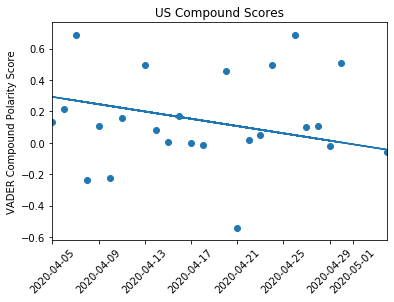

P-value: 0.115
Std Error: 0.008


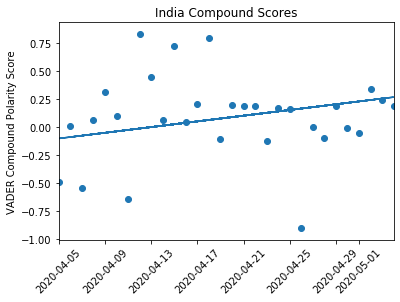

P-value: 0.216
Std Error: 0.008


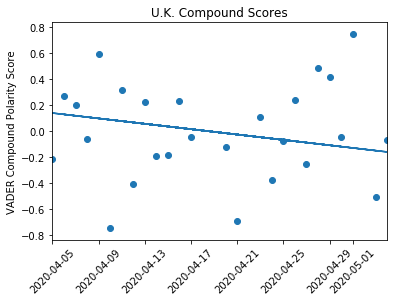

P-value: 0.782
Std Error: 0.009


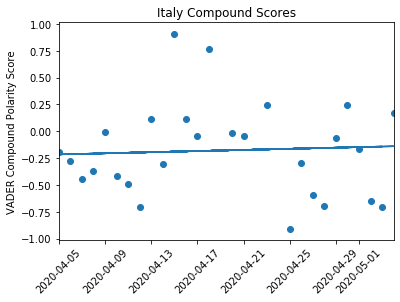

P-value: 0.729
Std Error: 0.009


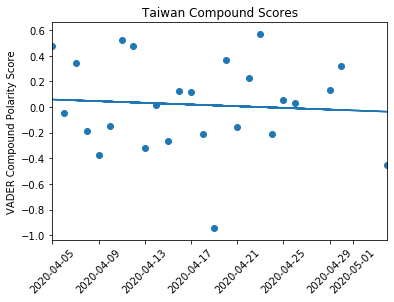

P-value: 0.587
Std Error: 0.007


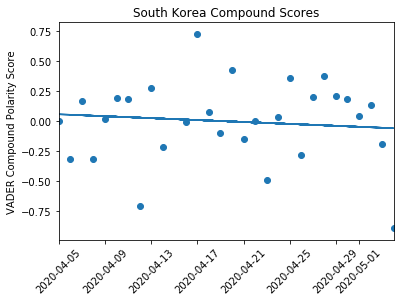

P-value: 0.466
Std Error: 0.009


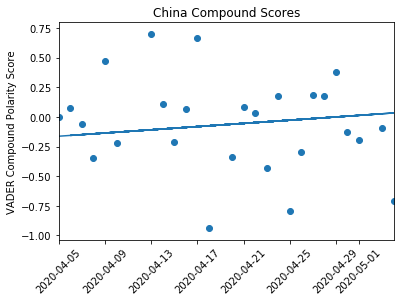

P-value: 0.977
Std Error: 0.009


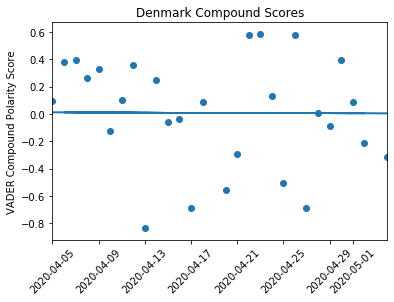

P-value: 0.337
Std Error: 0.008


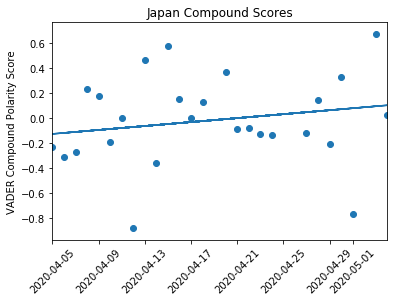

In [23]:
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from statistics import mean
from scipy import stats


def plot_by_date(country): #take country string
    """Input: str(country)
    Plots a country's average compound score per day
    with a linear regression
    """
    #Let's plot the average compound score by day
    country_date_dict = track_by_date(country)
    dates = list(country_date_dict.keys()) #keys in 'yyyy-mm-dd' format
    x = [dt.datetime.strptime(d,'%Y-%m-%d').date() for d in dates]

    #to convert back to string object so can call in dict
    #x[0].strftime('%Y-%m-%d')
    y = []
    for date in x:
        d = date.strftime('%Y-%m-%d') #string
        #china_date_dict[d] #list of dicts
        comp_list = [dict['compound'] for dict in country_date_dict[d]]
        y.append(sum(comp_list)/len(comp_list))


    tups = list(zip(x,y))
    tups.sort(key=lambda t: t[0])
    x_date = [tup[0] for tup in tups]
    y = [tup[1] for tup in tups]

    start_date = min(x)
    end_date = max(x)
    diff = end_date - start_date
    xs = list(range(diff.days))
    #print(mean(y))

    #print(x, y)
    x_ord = [i.toordinal() for i in x] 
    slope, intercept, r, p, std_err = stats.linregress(x_ord, y)
    def myfunc(x):
        return slope * x + intercept
    regression_line = list(map(myfunc, x_ord))
    #Sig P-value is 0.05
    print('P-value: %.3f\nStd Error: %.3f' %(p, std_err)) 


    plt.scatter(x_date,y)
    plt.plot(x, regression_line)
    plt.xlim(start_date, end_date)
    plt.xticks(rotation=45)
    plt.ylabel('VADER Compound Polarity Score')
    plt.title(country + ' Compound Scores')
    plt.show()
for country in long_list:
    plot_by_date(country)
        

P-value: 0.714
Std Error: 0.001


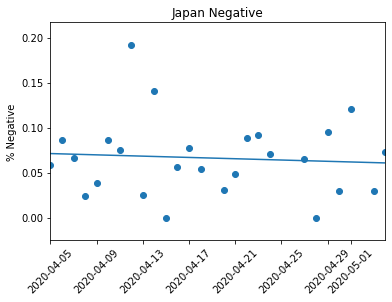

P-value: 0.048
Std Error: 0.001


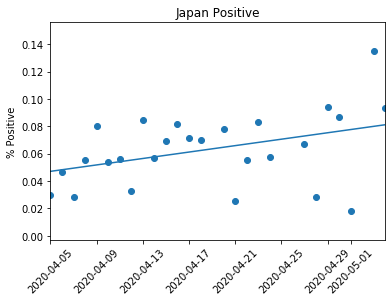

In [9]:
track_by_date('China')
#Plots compund by date
def pos_neg_by_date(country): #take country string
    """Takes country string and plots the positive and negative
    VADER sentiment scores rather than the compound scores. 
    Track the trend of percent positive and negative sentiment
    over time."""
    #Let's plot the average compound score by day
    country_date_dict = track_by_date(country)
    dates = list(country_date_dict.keys()) #keys in 'yyyy-mm-dd' format
    x = [dt.datetime.strptime(d,'%Y-%m-%d').date() for d in dates]

    #to convert back to string object so can call in dict
    #x[0].strftime('%Y-%m-%d')
    y_pos = []
    y_neg = []
    for date in x:
        d = date.strftime('%Y-%m-%d') #string
        #china_date_dict[d] #list of dicts
        pos_list = [scores['pos'] for scores in country_date_dict[d]]
        neg_list = [scores['neg'] for scores in country_date_dict[d]]
        y_pos.append(sum(pos_list)/len(pos_list))
        y_neg.append(sum(neg_list)/len(neg_list))
    x_neg, y_neg = prepare_for_plot(x, y_neg)
    x_pos, y_pos = prepare_for_plot(x, y_pos)
    plot_w_linreg(x_neg, y_neg, country, 'Negative')
    plot_w_linreg(x_pos, y_pos, country, 'Positive')
    


#Take x objects and y avg list         
def prepare_for_plot(x, y):
    tups = list(zip(x,y))
    tups.sort(key=lambda t: t[0])
    x_date = [tup[0] for tup in tups]
    y = [tup[1] for tup in tups]
    return x_date, y


def plot_w_linreg(x, y, country, feature):
    x_ord = [i.toordinal() for i in x]
    start_date = min(x)
    end_date = max(x)
    slope, intercept, r, p, std_err = stats.linregress(x_ord, y)
    def myfunc(x):
        return slope * x + intercept
    regression_line = list(map(myfunc, x_ord))
    #Sig P-value is 0.05
    print('P-value: %.3f\nStd Error: %.3f' %(p, std_err)) 
    plt.scatter(x,y) #xdate?
    plt.plot(x, regression_line)
    plt.xlim(start_date, end_date)
    plt.title(country + ' ' + feature)
    plt.ylabel('% '+ feature)
    plt.xticks(rotation=45)
    plt.show()

#Ex: Japan
#At the time of writing Japan had a p-value of 0.048 for the linreg showing an increase in % positive sentiment
pos_neg_by_date('Japan')

#More examples
#for country in long_list:
#    pos_neg_by_date(country)


In [24]:
#Used for word cloud
def plain_content(string1):
    # Extract words
    words = word_tokenize(string1)
    # Convert to lower case
    words = [w.lower() for w in words]
    # Clear punctuation
    table = str.maketrans('', '', string.punctuation)
    words = [w.translate(table) for w in words]
    #Lets also remove www and https
    words = [w for w in words if w[:3] != 'www']
    words = [w for w in words if w[:4] != 'http']
    #Remove blanks
    words = [w for w in words if w!= '']
    #Remove remaining character count
    if words[-1] == 'chars':
        words = words[:-2]
    #Remove ellipses
    if words[-1][-1:] == '…':
        words = words[:-1]
    return words

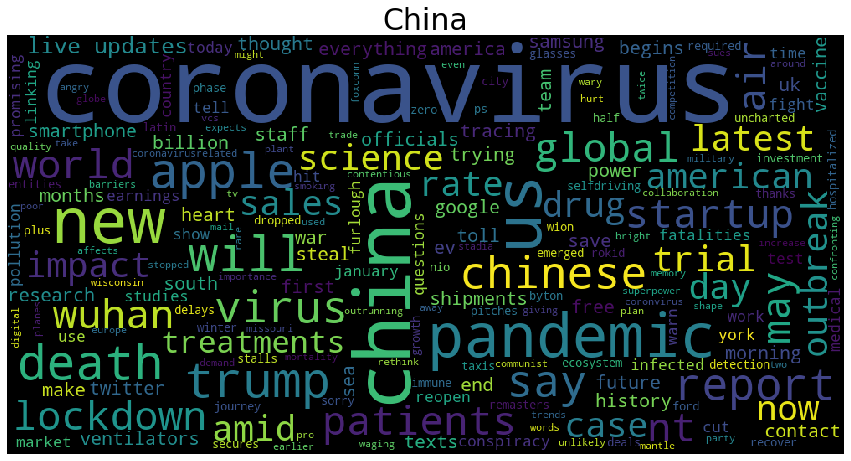

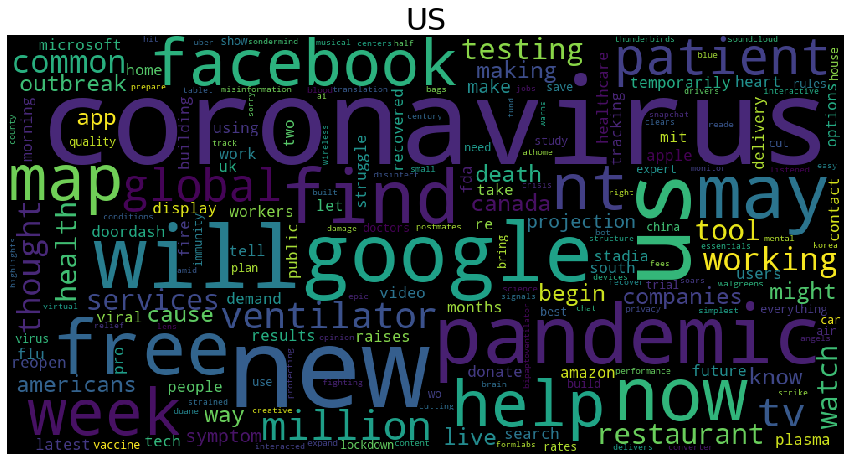

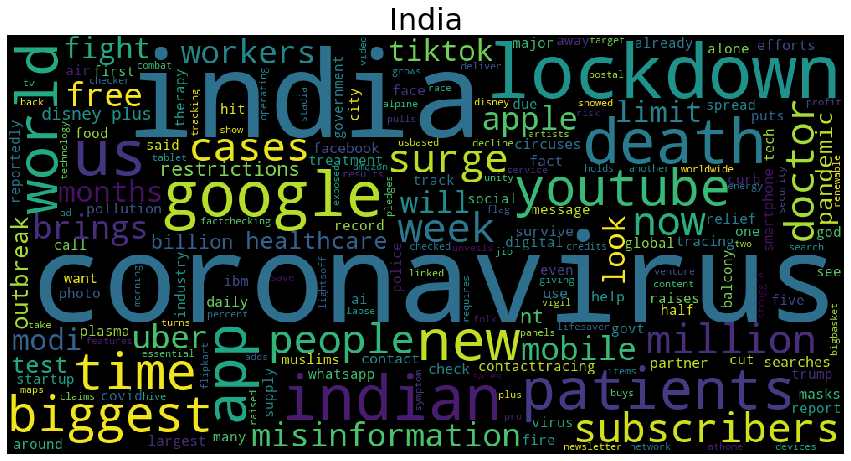

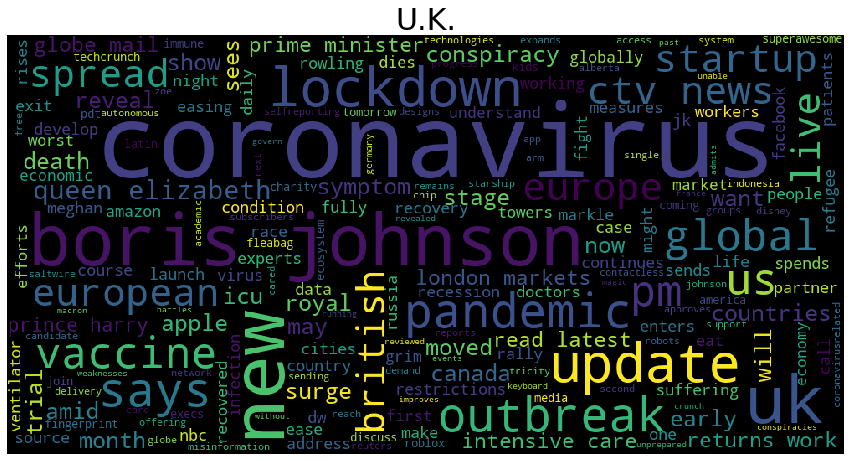

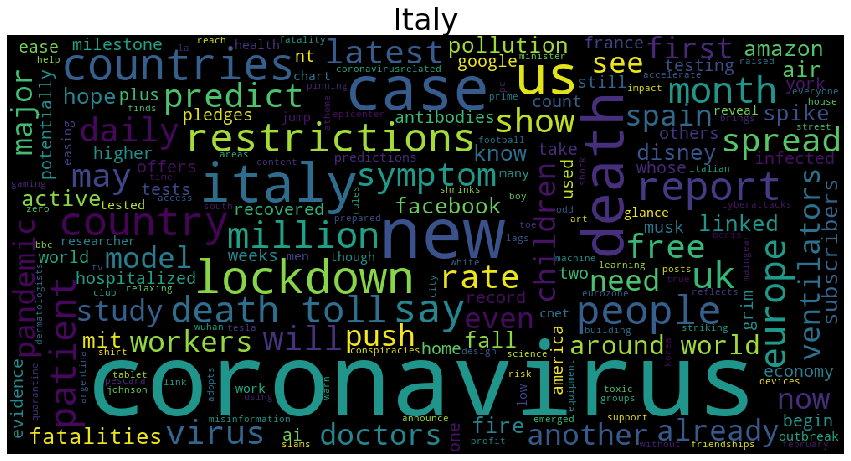

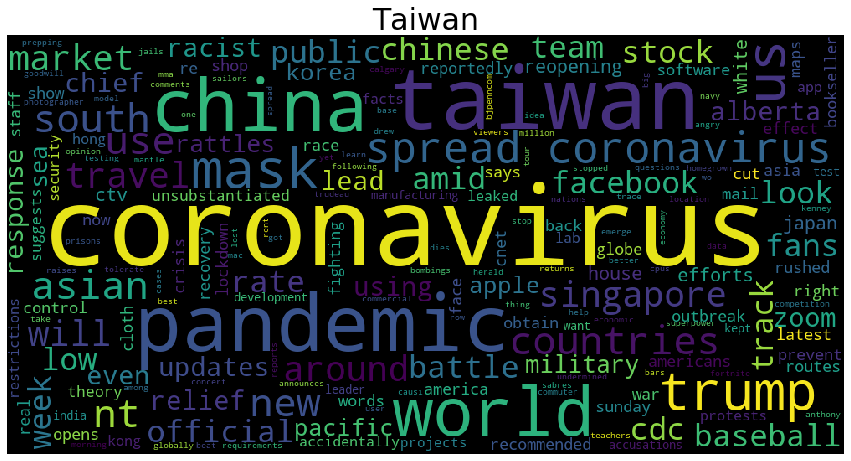

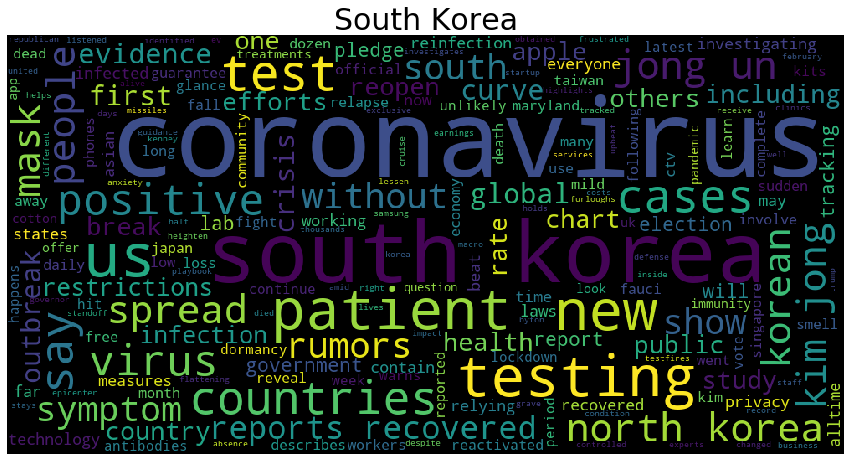

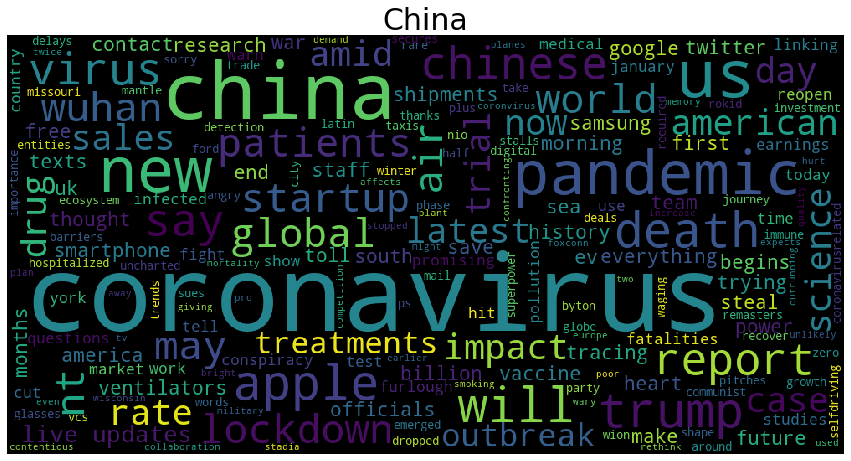

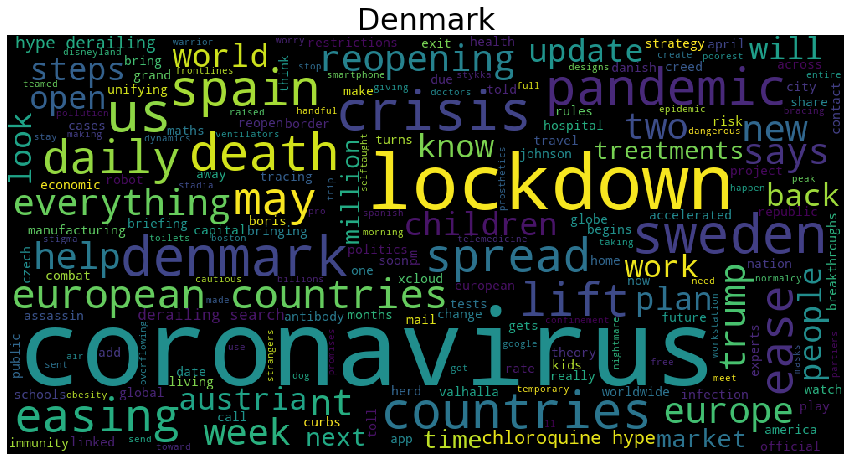

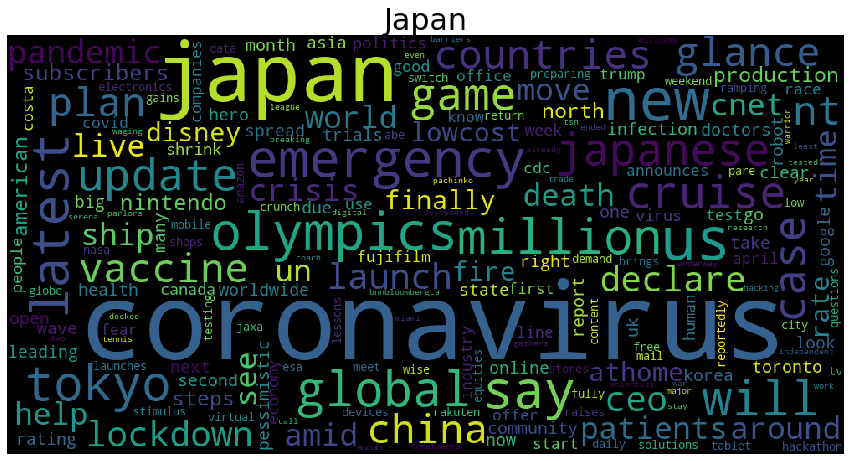

In [15]:
# importing packages
from wordcloud import WordCloud 
import matplotlib.pylab as plt

#function to plot a worldcloud
def plot_wordcloud(text,title):
    #convert list to string and generate
    words_string=(" ").join([str(elem) for elem in text]) #convert the list into a long string
    wordcloud = WordCloud(width = 1000, height = 500).generate(words_string)
    plt.figure(figsize=(15,8))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.savefig("your_file_name"+".png", bbox_inches='tight')
    plt.title("%s" %title, size = 30)
    plt.show()
    plt.close()

#Creates a flat lists and plots the corresponding word cloud
def create_flat_plot(country):
    # call two functions to get title, sources and content of the article
    new_content = get_content_date(get_country(country))
    plain_country =[] #an emprty list to add the content of the articles
    for tup in new_content: # another for loop to only choose tup[2] which refers to the content of the article
        if tup[2] is None:
            continue
        plain_country.append(plain_content(tup[2])) #generates list of words for all articles
    #convert a list of lists to a flat list
    flat_list = [item for sublist in plain_country for item in sublist] 
    #remove all the integers
    flat_list =[x for x in flat_list if not any(c.isdigit() for c in x)]
    #call the function to plot a word cloud
    plot_wordcloud(flat_list, country)
#Example
create_flat_plot('China')
    

#for loop to plot wordcloud for each country
for country in long_list:
    create_flat_plot(country)

In [16]:
senti = SentimentIntensityAnalyzer()
#
def track_by_country(state):
    state_content = get_content_date(get_country(state)) #ist of tup (source, date, title, article)
    #We'll create a diction, key date with a list of scores as the values
    list1 = []
    #Score by article?
    for source in state_content: #Source is a tup with (source, date, title, article)
        if source[3] is None:
            continue
        full_article = source[2] + '. ' +source[3] #title sep by period
        list1.append(full_article) #making a list of content from differnt article
    list1 = " ".join(list1) #converting the list into a long string 
    return senti.polarity_scores(list1) #calculating sentiment_Score 

score_list = [] #empty list to add the scores for each country
#calling the function (track_by_country) to make a list of sentiment score for countries
for country in long_list:
    new_list = [country,track_by_country(country)]
    score_list.append(new_list)
    #print("%s: " %(country),track_by_country(country))

<function matplotlib.pyplot.show(*args, **kw)>

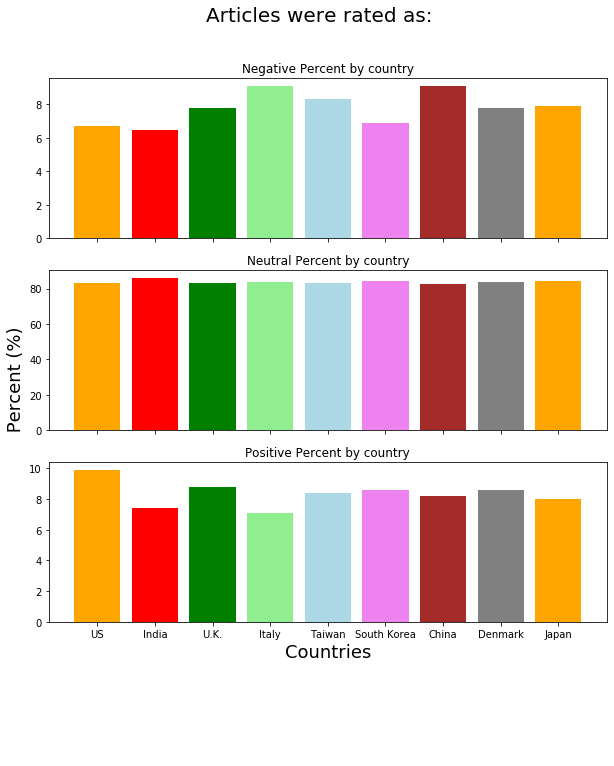

In [17]:
# running a for loop to create separate dictionary each for the three type of score (neg,neu and pos)
negative_percent={}
neutral_percent ={}
positive_percent= {}
for i in score_list:
    negative_percent = {**negative_percent, **{i[0]:(i[1]['neg'])*100}} 
    neutral_percent = {**neutral_percent, **{i[0]:(i[1]['neu'])*100}} 
    positive_percent = {**positive_percent, **{i[0]:(i[1]['pos'])*100}}
    
%matplotlib inline
#plotting the positive,negative sentiment score by each country
fig, (ax1,ax2,ax3) = plt.subplots(3,1,figsize=(10,10),sharex='col', sharey='row',)
plt.suptitle("Articles were rated as:",fontsize = 20)
ax1.title.set_text("Negative Percent by country")
ax1.bar(*zip(*negative_percent.items()),color=['orange', 'red', 'green','lightgreen', 'lightblue', 'violet','brown','grey'])
plt.ylabel("                                                         Percent (%)",fontsize = 18)
plt.xlabel("Countries",fontsize = 18)
ax2.title.set_text("Neutral Percent by country")
ax2.bar(*zip(*neutral_percent.items()),color=['orange', 'red', 'green','lightgreen', 'lightblue', 'violet','brown','grey'])
ax3.title.set_text("Positive Percent by country")
ax3.bar(*zip(*positive_percent.items()),color=['orange', 'red', 'green','lightgreen' ,'lightblue', 'violet','brown','grey'])
plt.show